In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from functools import reduce
from qulacs import QuantumState, QuantumCircuit
from qulacsvis import circuit_drawer

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.cm import ScalarMappable
from cycler import cycler

mpl.rcParams.update({'font.size': 18})
plt.rcParams['axes.axisbelow'] = True

## seed of random number
random_seed = 42
## initialization of random number generator
np.random.seed(random_seed)

from sklearn.model_selection import train_test_split


El objetivo es optimizar un circuito para transmitir un estado del primer qubit al último.

In [2]:
# Parámetros del circuito
nqubit = 4
cdepth = 3

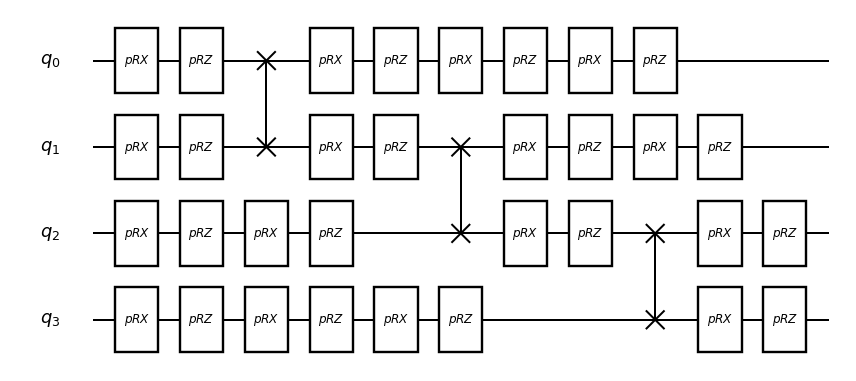

In [3]:
from qulacs import ParametricQuantumCircuit

qc = ParametricQuantumCircuit(nqubit) # circuito de nqubit qubits

#qc.add_X_gate(0) # NOT gate on qubit 0 to convert into |1>

for d in range(cdepth):

    for i in range(nqubit):
        angle = np.random.rand()*2*np.pi
        qc.add_parametric_RX_gate(i,angle)
        angle = np.random.rand()*2*np.pi
        qc.add_parametric_RZ_gate(i,angle)
    qc.add_SWAP_gate(d,d+1)
for i in range(nqubit):
        angle = np.random.rand()*2*np.pi
        qc.add_parametric_RX_gate(i,angle)
        angle = np.random.rand()*2*np.pi
        qc.add_parametric_RZ_gate(i,angle)

circuit_drawer(qc,'mpl')

In [4]:
# Acceder a valores de los parámetros
parameter_count = qc.get_parameter_count()
theta_init = [qc.get_parameter(ind) for ind in range(parameter_count)]
print(f'Initial {parameter_count} parameters: {theta_init}')

Initial 32 parameters: [2.353304971691044, 5.9735141613602165, 4.599253580133889, 3.761482191925223, 0.980294029274052, 0.9801424781769557, 0.3649500985631483, 5.442345232562516, 3.776917009710014, 4.448951217224888, 0.12933619211510794, 6.094123332392967, 5.230391369746984, 1.3341659803533248, 1.1424399624340646, 1.152364521581569, 1.9116103907867292, 3.297141901079666, 2.713990594641554, 1.8298466547148808, 3.844385118274953, 0.8764657756906659, 1.8355989632476268, 2.3019193508941536, 2.865572223878106, 4.933406064175189, 1.2545873742863833, 3.23103026788615, 3.7222505148331146, 0.29185655071471744, 3.8173168869197154, 1.0714346684716647]


In [5]:
from qulacs.state import inner_product

state1 = QuantumState(nqubit)
nstate = QuantumState(nqubit)

state1.set_computational_basis(0b0001)
nstate.set_computational_basis(0b1000)
print(state1.get_vector())



# Create observable Z_0
from qulacs import Observable

z0 = Observable(nqubit)
z0.add_operator(1.,'Z 0')

z1 = Observable(nqubit)
z1.add_operator(1.,'Z 1')

z2 = Observable(nqubit)
z2.add_operator(1.,'Z 2')

z3 = Observable(nqubit)
z3.add_operator(1.,'Z 3')

print(z0.get_expectation_value(nstate))
print(z1.get_expectation_value(nstate))  
print(z2.get_expectation_value(nstate))
print(z3.get_expectation_value(nstate))


[0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
1.0
1.0
1.0
-1.0


In [6]:
# Función que predice el valor y(x_i,theta) del modelo a partir del input x_i
def qcl_pred(qc):
    #.set_zero_state()
    state = QuantumState(nqubit)
    state.set_computational_basis(0b0001)
    # Calculate output state
    calcstate = qc.update_quantum_state(state)
    # Output of the model
    res =  calcstate   #[z0.get_expectation_value(state),z1.get_expectation_value(state),z2.get_expectation_value(state),z3.get_expectation_value(state)]
    return res

# Function that updates parameter theta
def set_U_out(theta):

    global U_out
    global qc
    
    parameter_count = qc.get_parameter_count()

    for i in range(parameter_count):
        qc.set_parameter(i, theta[i])

# Cálculo de función costo
def cost_func(theta):
    '''
    theta: ndarray of length c_depth * nqubit * 3
    '''    
    
    #state1 = qcl_pred(qc)
    nstate = QuantumState(nqubit)
    nstate.set_computational_basis(0b1000)
    

    state = QuantumState(nqubit)
    state.set_computational_basis(0b0001)
    print( 'loss: ', 1-np.abs(inner_product(state,nstate)))  #-y_pred[3] + y_pred[0] + y_pred[1] + y_pred[2]

    set_U_out(theta)
    
    qc.update_quantum_state(state)
    
    print( 'loss: ', 1-np.abs(inner_product(state,nstate)))  #-y_pred[3] + y_pred[0] + y_pred[1] + y_pred[2]

    # calcular predicciones para el conjunto de entrenamiento
    #y_pred = qcl_pred(qc)
    #state1 = QuantumState(nqubit)



    print(inner_product(state,nstate))
    # Error cuadrático medio 
    L = 1-np.abs(inner_product(state,nstate))  #-y_pred[3] + y_pred[0] + y_pred[1] + y_pred[2]
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = theta
    cost_history_dict["cost_history"].append(L)

    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {L}]")

    return L


loss:  1.0
loss:  0.7334868860077717
(0.23148070587074293+0.13208301457574745j)
Iters. done: 1 [Current cost: 0.7334868860077717]
loss:  1.0
loss:  0.726014291478136
(0.25053430443694424+0.11090865960115284j)
Iters. done: 2 [Current cost: 0.726014291478136]
loss:  1.0
loss:  0.7827499501566111
(0.20517443048940137+0.07142154598092074j)
Iters. done: 3 [Current cost: 0.7827499501566111]
loss:  1.0
loss:  0.7394184531189387
(0.22328563633112727+0.13433639560123062j)
Iters. done: 4 [Current cost: 0.7394184531189387]
loss:  1.0
loss:  0.7296971550850299
(0.23159953301328642+0.13937461848254168j)
Iters. done: 5 [Current cost: 0.7296971550850299]
loss:  1.0
loss:  0.7274136782913507
(0.23708516025933066+0.13451367799394506j)
Iters. done: 6 [Current cost: 0.7274136782913507]
loss:  1.0
loss:  0.7330093647928736
(0.231161364048486+0.1335979904772081j)
Iters. done: 7 [Current cost: 0.7330093647928736]
loss:  1.0
loss:  0.7319464601282959
(0.23225880449989394+0.13382282305358573j)
Iters. done: 8 

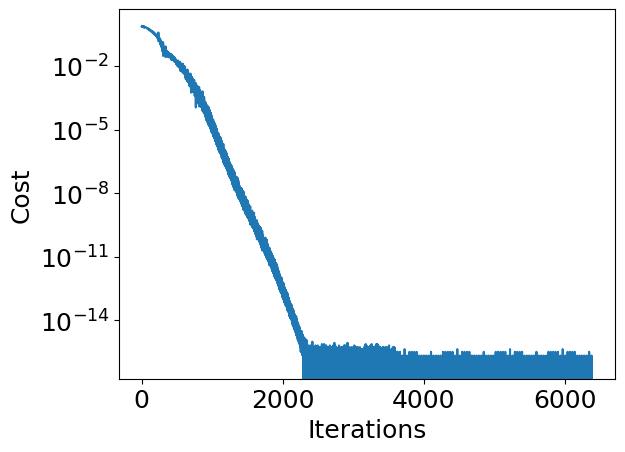

In [7]:
from scipy.optimize import minimize
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
result = minimize(cost_func, theta_init, method='Nelder-Mead', tol=1e-16)
print(result.message)
print(result.fun)
print(result.x/np.pi)

all(cost_history_dict["prev_vector"] == result.x)
cost_history_dict["iters"] == result.nfev
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.axhline(y=0, color='r', linestyle='--', label="Energía objetivo (-1.84)")
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
ax.set_yscale("log")
plt.draw()

In [8]:
parameter_count = qc.get_parameter_count()
theta_fin = [qc.get_parameter(ind) for ind in range(parameter_count)]
print(f'Final {parameter_count} parameters: {theta_fin}')


Final 32 parameters: [2.4177610424180473, 7.185610386645747, 4.7214785500131775, 4.009804567553594, 1.1102296325277998, 1.1047044791479825, 0.3685972174707909, 4.583472596341926, 3.86713869722532, 4.0696099047487255, 0.12379028625758515, 4.17936428213298, 6.45041809764556, 1.2450294167285847, 0.9548149973863818, 0.9040860768470869, 1.862915367413975, 3.5703091717456843, 2.471146363663796, 2.3592821575519825, 4.176868125382333, 0.7844589665505279, 1.9015878178102175, 2.2815242790239463, 2.9829510144514613, 4.664653015777185, 1.4841499209515532, 2.8361627950722257, 2.652096284091595, 0.2617232092706292, 5.423557609949478, 0.8862958006659685]


In [11]:
state = QuantumState(nqubit)
state.set_computational_basis(0b0001)
# Calculate output state
print(state.get_vector())
print(z0.get_expectation_value(state))
print(z1.get_expectation_value(state))  
print(z2.get_expectation_value(state))
print(z3.get_expectation_value(state))

set_U_out([np.pi*2 for i in range(0,32)])
circuit_drawer(qc,'mpl')
qc.update_quantum_state(state)
print(state.get_vector())
z0 = Observable(nqubit)
z0.add_operator(1.,'Z 0')

z1 = Observable(nqubit)
z1.add_operator(1.,'Z 1')

z2 = Observable(nqubit)
z2.add_operator(1.,'Z 2')

z3 = Observable(nqubit)
z3.add_operator(1.,'Z 3')

print(z0.get_expectation_value(state))
print(z1.get_expectation_value(state))  
print(z2.get_expectation_value(state))
print(z3.get_expectation_value(state))


[0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
-1.0
1.0
1.0
1.0
[-7.79875087e-31-4.89858720e-16j -2.39961565e-31+2.35094530e-46j
 -2.39961565e-31+2.35094530e-46j  4.31861646e-62+1.17547265e-46j
 -2.39961565e-31+2.35094530e-46j  4.31861646e-62+1.17547265e-46j
  4.31861646e-62+1.17547265e-46j  5.75815528e-62+1.41034129e-77j
  1.00000000e+00-9.79717439e-16j -1.79971174e-31-4.89858720e-16j
 -1.79971174e-31-4.89858720e-16j -2.39961565e-31-5.87736326e-47j
 -1.79971174e-31-4.89858720e-16j -2.39961565e-31-5.87736326e-47j
 -2.39961565e-31-5.87736326e-47j -1.00767717e-61+1.17547265e-46j]
1.0
1.0
1.0
-1.0
